In [1]:
###########################
##     메모리 체크       ##

!nvidia-smi

'''
메모리 오류 생길 시
1. 데이터 새는 부분 없는지 확인할것(ex. evaluate하는데 torch.no_grad 안돼 있다거나..)

2. conv에서 size 너무 크지않은지 확인

3. 파이프라인 쪼개기(한 kernel에서 imagetransform, 다른 kernel에서 training 등등)
3. batch size 줄이기

4. Holding python variable
    ex) for x, y in train_loader:
            x = torch.tensor(x, device=device, dtype=torch.float32)
            z = model(x)
            features.append(z)
            
            에서
            
        for x, y in train_loader:
            x = torch.tensor(x, device=device, dtype=torch.float32)
            z = model(x)
            features.append(z.tolist())
            
           로 변경
           
5. dtype변경 -> net(model) 에서 요구하는 type이랑 맞춰야 돼서 귀찮음, 효과도 미미
    windows에서 x64도 dtype=int32로 설정된다고 함
    train, test 의 input tensor 에 .to(torch.int64) 붙이면 될때 있음
    
6. torch.cuda.empty_cache() 사용 -> 크게 도움 안됨, 한 fold나 돌렸을때 써주면 미미하게 도움되는듯
7. gc.collect() 사용 -> 크게 도움 안됨, 한 fold나 돌렸을때 써주면 미미하게 도움 되는듯
 
'''
import warnings
warnings.filterwarnings(action='ignore')


Fri May 28 02:25:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.89       Driver Version: 460.89       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8     2W /  N/A |    224MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import os, random, gc
import re, time, json
from  ast import literal_eval


from IPython.display import Audio
from sklearn.metrics import label_ranking_average_precision_score

from tqdm.notebook import tqdm
import joblib

import pretrainedmodels

from sklearn.model_selection import StratifiedKFold


In [3]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm  ##다양한 model들 있는 라이브러리

In [4]:
## SparseImageWarp 불러오기위한 경로로 이동 (폴더내에 위치한 spec_augment_master 위치)

%cd /Users/ansgh/PycharmProjects/kaggle_notebook/input/spec_augment-master/

import ipynb
import SparseImageWarp
from ipynb.fs.full.SparseImageWarp import sparse_image_warp

C:\Users\ansgh\PycharmProjects\kaggle_notebook\input\spec_augment-master
torch.Size([1, 4, 4]) torch.Size([1, 4, 2])
torch.Size([1, 4, 4]) torch.Size([1, 4, 2])


In [5]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [6]:
##################
## Seed Setting ##
##################

def make_seed(seed = 499):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(seed)
    
make_seed()

Num_classes = 397 ##label할 classes 갯수(ex 새 종류)
SR = 32000 #sampling rate
Duration = 7 #time
seed = 599
n_splits = 5

In [7]:
###############################################
'''
                 PIPE LINE 1
                 Data 전처리
              melspec computing
                                              '''
###############################################


''' 
    
    
    
데이터 셋이 너무 큰 경우 Part_id 로 쪼개서 작업할수도 있음
get_df 에서 학습용 df 전처리 하는게 유리할것. (df.rating이 일정이하면 학습에 안쓰겠다 등등)




'''



' \n    \n    \n    \n데이터 셋이 너무 큰 경우 Part_id 로 쪼개서 작업할수도 있음\nget_df 에서 학습용 df 전처리 하는게 유리할것. (df.rating이 일정이하면 학습에 안쓰겠다 등등)\n\n\n\n\n'

In [8]:
#################
## Path manage ##
#################

Root_Path = '/Users/ansgh/PycharmProjects/kaggle_notebook/input/birdclef-2021'

Train_short_root = Path(Root_Path + str('/train_short_audio'))
Train_metadata_root = Path(Root_Path + str('/train_metadata.csv'))

Train_audio_image_save_root = Path(Root_Path + str('/audio_images'))
Train_audio_image_save_root.mkdir(exist_ok=True, parents=True)

## File 내부 확인 
file_list = os.listdir(Root_Path)
print(file_list)

['audio_images', 'efficientnet_sr32000_d7_v1_v1', 'Label_IDS.json', 'Label_IDS_0.json', 'resnet152_sr32000_d7_v1_v1', 'resnext_sr32000_d7_v1_v1', 'rich_train_metadata.csv', 'rich_train_metadata_0.csv', 'sample_submission.csv', 'test.csv', 'test_soundscapes', 'train_metadata.csv', 'train_short_audio', 'train_soundscapes', 'train_soundscape_labels.csv']


In [11]:
#####################
## Audio File info ##
#####################

def get_audio_info(filepath):
    with SoundFile(filepath) as f:
        sr = f.samplerate
        frames = f.frames
        duration = float(frames)/sr
        
    return {'frames': frames, 'sr':sr, 'duration': duration}

#오디오 파일에서 sr, running_time, frame 이 제일 중요한 정보기 때문에 이것들만 dic에 저장

In [12]:
###############################################
## 데이터셋이 클때 분할하기 위한 테크닉      ##
##   이거 한 후에 make_df함수에서 쓰면 됨    ##
###############################################

Part_id = 0
Part_indexs = np.linspace(0, 62874, 5)  #birdclef 가 62874개라 5분할
Part_indexs = list(map(int, Part_indexs)) #분할한후 index로 쓸것이기때문에 int로 치환

Part_indexs

[0, 15718, 31437, 47155, 62874]

In [13]:
################################################
##       Metadata + Audio_info 해서           ##
##              DataFrame 생성                ##
################################################

def make_df(n_splits = 5, seed = seed, nrows = None):
    
    df = pd.read_csv(Train_metadata_root, nrows=nrows) #전체열 다 불러옴
    Label_IDS = {label: label_id for label_id, label in enumerate(sorted(df['primary_label'].unique()))}  #고유종마다 ids 부여, ex 참새 = 0, 비둘기 = 1

    
    df = df.iloc[Part_indexs[Part_id] : Part_indexs[Part_id + 1]] #5분할중에 한파트
    df['label_id'] = df['primary_label'].map(Label_IDS) ##Primary Label을 기준으로 같은 종마다 같은 Label_IDS 배정 ex.참새_1 = 0, 참새_2 = 0, 비둘기 = 1 
    df['filepath'] = [str(Train_short_root/primary_label/filename) for primary_label, filename in zip(df.primary_label, df.filename)] #df에 file_path 추가

    
    pool = joblib.Parallel(6) ##병렬처리해서 속도up
    mapper = joblib.delayed(get_audio_info) #get_audio_info 함수
    tasks = [mapper(filepath) for filepath in df.filepath]
    # df의 filepath열에 저장된 filepath를 get_audio_info에 넣고 모든 병렬처리 끝날때까지 기다리도록 설정
    
    
    audio_info_index = []
    for i in range( Part_indexs[Part_id], Part_indexs[Part_id + 1] ):
        audio_info_index.append(i)
        
    df = pd.concat([df, pd.DataFrame( pool(tqdm(tasks)), index=audio_info_index )], axis=1, sort=False) #원래df 옆에 task한거(get_audio_info 결과) 붙임
    
    
    #나중에 K-Fold 쓰기위해서 Fold할 number를 df에 labeling
    skf = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
    splits = skf.split(np.arange(len(df)), y=df.label_id.values)
    df['fold'] = -1
    
    for fold, (train_set, val_set) in enumerate(splits):
        df.loc[df.index[val_set], 'fold'] = fold
    
    return Label_IDS, df

In [99]:
# 합친 Data_Frame 생성 (Part_id == 0 이기 때문에 5개를 loop로 5개 다 돌려야 전체 데이터 셋임)
for Part_id in range(4):
    Label_IDS, df = make_df()

    # 새 df를 csv로 저장
    df.to_csv(Root_Path + f'/rich_train_metadata_{Part_id}.csv', index=True)
    
    #json이 data 전송할때 더 유리하다고 함, json도 같이 저장해줍시다.
    with open(Root_Path + f'/Label_IDS_{Part_id}.json', 'w') as f: ## Label_IDS.json 이름의 파일을 'w'rite모드로 열어서
        json.dump(Label_IDS, f) #Label_IDS 객채를 json_file에 넣음
        
    get_audios_as_images(df) ##이건 넘어갔다가 Audio_do_image 파트 보고 다시올것.

  0%|          | 0/15718 [00:00<?, ?it/s]

  0%|          | 0/15718 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
#######################################
##                                   ##  
## 음성처리 위한 Melspectrogram 계산 ## 
##                                   ##
#######################################

class MelSpecComputer:
    def __init__(self, sr, n_mels, fmin, fmax, **kwargs):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        kwargs['n_fft'] = kwargs.get('n_fft', self.sr//10) ##SR//10으로 n_fft 설정
        kwargs['hop_length'] = kwargs.get('hop_length', self.sr//(10*4)) ##hop length == fft마다 겹치는 길이
        self.kwargs = kwargs
    
    
    def __call__(self, audio):
        
        melspec = lb.feature.melspectrogram(
            audio, sr=self.sr, n_mels=self.n_mels, fmin=self.fmin, fmax=self.fmax, **self.kwargs
        )
        melspec = lb.power_to_db(melspec).astype(np.float32)
        
        return melspec

In [14]:
#########################################
##          Mel Image normalize        ##   
## 이미지 노말라이징 안하면 너무 밝음  ##
#########################################

def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

In [15]:
######################################
##          Crop Padding            ##   
## 규격에 맞게 사이즈 trimming 하기 ##
######################################

def crop_or_pad(y, length, is_train=True, start=None):
    # y가 규격보다 짧으면
    if len(y) < length:
        y = np.concatenate([y, np.zeros(length - len(y))]) ## 부족한 길이를 0우로 padding 함
        
        n_repeats = length // len(y)
        epsilon = length % len(y)
        
        y= np.concatenate([y]*n_repeats + [y[:epsilon]]) ##적당히 채워줌
        
    # y가 규격보다 길면    
    elif len(y) > length:
        if not is_train:
            start = start or 0
        else:
            start = start or np.random.randint(len(y) - length)
            
        y = y[start : start + length] ##이러면 length짜리 y로 변경됨
        
        
    return y

In [9]:
############################                  
##   Audio to Image       ##
############################


class AudioToImage:
    def __init__(self, sr=SR, n_mels=128, fmin=0, fmax=None, duration=Duration, step=None, res_type='kaiser_fast', resample=True):
        
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2 ##안넣으면 nyquist로 씀
        self.duration = duration
        self.audio_length = self.duration * self.sr #audio들은 길이가 다 다르기 때문에 audio_length만큼씩 같은 길이로 토막내서 보관
        self.step = step or self.audio_length
        self.res_type = res_type
        self.resample = resample
        
        self.mel_spec_computer = MelSpecComputer(sr=self.sr, n_mels=self.n_mels, fmin=self.fmin, fmax=self.fmax)
        
    def audio_to_image(self, audio):
        melspec = self.mel_spec_computer(audio)
        image = mono_to_color(melspec)
        
        return image
    
    def __call__(self, row, save=True):
        audio, orig_sr = sf.read(row.filepath, dtype='float32')
        
        #전처리 Audio_to_img 하기전에 음성과 우리의 sr이 안맞으면 안되기때문에..
        if self.resample and orig_sr != self.sr: #resampling이 요청되거나(sampling rate가 안맞을때)
            audio = lb.resample(audio, orig_sr, self.sr, res_type=self.res_type)
          
        
        ##본처리
        
        #먼저 음성마다 다른 길이를 맞춰주기 위해서 같은 길이로 샘플링할것임
        # audio길이를 i:i+audio_len 즉 audio_len만큼 읽을건데, i범위는 0부터 총길이-원하는길이 , 원하는 길이 간격으로
        # 즉 audios에 저장 되는것은 [0~audio_len, audio_len~2*audio_len, ..... ,x*audio_len~총길이] 이런식으로 샘플링해서 저장
        audios = [audio[i: i+self.audio_length] for i in range(0, max(1, len(audio) - self.audio_length+1), self.step)]
        # 마지막 (x*audio_len ~ 총 길이) 인 샘플은 총 길이가 (x+1)*audio_len 이 아니면 더 짧게 나올것임, 따라서 crop_padding해줌
        audios[-1] = crop_or_pad(audios[-1], length=self.audio_length)
        
        #audios에 잘라서 넣은 audio들을
        images = [self.audio_to_image(audio) for audio in audios]
        images = np.stack(images)
        
        
        #저장
        if save:
            path = Train_audio_image_save_root/f"{row.primary_label}/{row.filename}.npy"
            path.parent.mkdir(exist_ok=True, parents=True) #parent는 상위경로도 생성한다는 뜻
            np.save(str(path), images)
        
        else:
            return row.filename, images

In [10]:
## Audio to Image 실행

def get_audios_as_images(df):
    pool = joblib.Parallel(2)
    converter = AudioToImage(step=int(Duration*0.666*SR)) ##Step ==audio_length
    mapper = joblib.delayed(converter)
    tasks = [mapper(row) for row in df.itertuples(False)]

    pool(tqdm(tasks))

In [18]:
'''
# For example.. we can see longest duration mel image
row_example = df.loc[df.duration.idxmax()]
mels_example = np.load(str((Train_audio_image_save_root/row.primary_label/row.filename).as_posix() + '.npy'))
print(mels_example.shape)
lbd.specshow(mels_example[0])
# as_posix 쓰면 str 안에 존재하는 \ 가 | 로 바뀜
'''

"\n# For example.. we can see longest duration mel image\nrow_example = df.loc[df.duration.idxmax()]\nmels_example = np.load(str((Train_audio_image_save_root/row.primary_label/row.filename).as_posix() + '.npy'))\nprint(mels_example.shape)\nlbd.specshow(mels_example[0])\n# as_posix 쓰면 str 안에 존재하는 \\ 가 | 로 바뀜\n"

In [51]:
###############################################
'''
                 PIPE LINE 2.0
                 Data 불러오기
  melspec computing 후 저장한 Label_IDS.json 과
        rich_train_meta.csv 불러오기
        
            dataset으로 저장
                                              '''
###############################################


''' 
    




'''


' \n    \n\n\n\n\n'

In [9]:
###
##  Mel 이미지를 만들었으니 이제는 train이랑 model 만들어야함
###

## df.to_csv(Root_Path + '/rich_train_metadata.csv', index=True) 있었음

Rich_train_path = Path(Root_Path + '/rich_train_metadata.csv')
Train_label_paths = Path(Root_Path + '/Label_IDS.json')
MODEL_ROOT = Path(".") ##save 할때 씀

# 만약 n개로 쪼개진 파일이라면(파일이름이 d-part1, d-part2, d-part3 등으로 돼 있다면)
# Rich_train_path = sorted(Path("블라블라/d-part?./rich_train_metadata.csv")) 로 읽고
# get_df에서 for path in file_path 로 하나씩 읽으면 됨. d-part?랑 sorted 때문에 iter 사용가능

In [10]:
#####################################
##   저장된 Data Frame 불러와서    ##
##    impath 맨 뒤에 붙이기        ##
##    make_df도 있음 초반부에      ##
#####################################
## get_df 에서 학습용 df 전처리 하는게 유리할것. (df.rating이 일정이하면 학습에 안쓰겠다 등등)

def get_df(file_path = Rich_train_path, label_path = Train_label_paths):
    
    df = None  #빈 df 생성
    Label_IDS = {}  #빈 label 생성
    
    
    temp = pd.read_csv(str(file_path), index_col = False) ##index_col = False면 column을 index로 안쓰고 순서대로 index부여
    
    temp['impath'] = temp.apply(lambda row: file_path.parent/'audio_images/{}/{}.npy'.format(row.primary_label, row.filename), axis=1)
    #impath = sound_path + audio_images + primary_label + filename 으로 불러오겠다
        
    df = temp if df is None else df.append(temp)
        
        
    df['secondary_labels'] = df['secondary_labels'].apply(literal_eval) ## 예를들어 second_label에 ['amegfi'] 를 [amegfi] 로 바꿔줌
        
    
    with open(str(label_path)) as f:
        Label_IDS.update(json.load(f))
                
    return Label_IDS, df




''' n개로 쪼개진 파일일때 예시

def get_df(file_path = Rich_train_path, label_path = Train_label_paths):
    
    df = None  #빈 df 생성
    Label_IDS = {}  #빈 label 생성
    
    for path in file_paths:
        temp = pd.read_csv(str(file_path), index_col = 0)
        temp['impath'] = temp.apply(lambda row: file_path.parent/'audio_images/{}/{}.npy'.format(row.primary_label, row.filename), axis=1)
        
        df = temp if df is None else df.append(temp)
        
        
        df['secondary_labels'] = df['secondary_labels'].apply(literal_eval) ## 예를들어 second_label에 ['amegfi'] 를 [amegfi] 로 바꿔줌
        
    for path in label_path:
        with open(str(path)) as f:
            Label_IDS.update(json.load(f))
                
    return Label_IDS, df

'''

" n개로 쪼개진 파일일때 예시\n\ndef get_df(file_path = Rich_train_path, label_path = Train_label_paths):\n    \n    df = None  #빈 df 생성\n    Label_IDS = {}  #빈 label 생성\n    \n    for path in file_paths:\n        temp = pd.read_csv(str(file_path), index_col = 0)\n        temp['impath'] = temp.apply(lambda row: file_path.parent/'audio_images/{}/{}.npy'.format(row.primary_label, row.filename), axis=1)\n        \n        df = temp if df is None else df.append(temp)\n        \n        \n        df['secondary_labels'] = df['secondary_labels'].apply(literal_eval) ## 예를들어 second_label에 ['amegfi'] 를 [amegfi] 로 바꿔줌\n        \n    for path in label_path:\n        with open(str(path)) as f:\n            Label_IDS.update(json.load(f))\n                \n    return Label_IDS, df\n\n"

In [11]:
Lable_IDS, df = get_df()

In [12]:
#########################################
##         Rating 기준으로 삭제        ##
##            in Data Frame            ##
#########################################
## data 수가 줄어듦 -> fold를 적게 나눠서 데이터 셋을 늘려서 상회시켜보자
'''
df_low_rating = df[(df['rating'] > -1) & (df['rating'] < 3.5)]

df.drop(df_low_rating.index, inplace = True)
df.reset_index(drop=True, inplace=True)## 이거 안해주면 중간에 인덱스가 1,2,3,4,8,9,10,13 처럼 빈거 생겨서 이터에러뜸


df.rating.value_counts()'''

"\ndf_low_rating = df[(df['rating'] > -1) & (df['rating'] < 3.5)]\n\ndf.drop(df_low_rating.index, inplace = True)\ndf.reset_index(drop=True, inplace=True)## 이거 안해주면 중간에 인덱스가 1,2,3,4,8,9,10,13 처럼 빈거 생겨서 이터에러뜸\n\n\ndf.rating.value_counts()"

In [13]:
#########################################
##   불러온 Data Frame 에 맞는         ##
##    impath에 해당하는 npy 불러와서   ##
##        dic으로 매칭                 ##
#########################################

Max_read_samples = 5 #메모리 아끼려고 5개만 불러오자 ##load_row에서 return row.filename, np.load(str(row.impath))[:MAX_READ_SAMPLES] 사용
def load_data(df):
    
    '''''''''''' ##여기 수정해서 row 받을때 quality 좋은것만 받을것
    
    def load_row(row):
        # filename = .ogg,  impath = .npy
        return row.filename, np.load(str(row.impath))
    
    
    pool = joblib.Parallel(4) #병렬처리
    mapper = joblib.delayed(load_row)
    tasks = [mapper(row) for row in df.itertuples(False)]
    res = pool(tqdm(tasks))
    res = dict(res)
    
    return res

In [14]:
## filename이랑 음성.npy랑 dic 타입으로 저장
audio_image_store = load_data(df)

  0%|          | 0/62874 [00:00<?, ?it/s]

In [15]:
## audio_image가 잘 저장됐는지 확인(길이로 대강만 보자 일단)
len(audio_image_store)

62874

In [16]:
###################################
##        Dataset 만들기          ##
##    numpy 3층으로 image 쌓고    ##
##     label은  smoothing 해서    ##
##         image, label 반환      ##
####################################

class BirdClefDataset(Dataset):
    
    def __init__(self, audio_image_store, meta, sr=SR, is_train=True, num_classes=Num_classes, duration=Duration):
        
        self.audio_image_store = audio_image_store ##audio np array랑 filename 저장된 dic
        self.meta = meta.copy().reset_index(drop=True) ##meta는 df
        self.sr = sr
        self.is_train = is_train
        self.num_classes = num_classes
        self.duration = duration
        self.audio_length = self.duration * self.sr
        
    
    def normalize(self, image):
        image = image.astype('float32', copy=False) / 255.0
        image = np.stack([image, image, image])
        return image
    
    def __len__(self):
        return len(self.meta)
    

    
    ##이 dataset의 단점이 있는 파트
    def __getitem__(self, idx):
        row = self.meta.iloc[idx]  #df에서 데이터 하나 불러옴
        image = self.audio_image_store[row.filename] #불러온 데이터의 filename으로 audio_image_store에서 image에 해당하는 np array 받아서 image에 저장
        

        #image에 저장된 np array는 (x, 128, 281)로써, 음성(.ogg)가 25초라면 7초씩 저장했으므로 x==4, 이미지크기==128,281 이라는 뜻. len(image)는 맨 앞 x를 반환한다.
        #즉 윗줄이 뜻하는 것은 AudioToImage 클래스로 image에 저장시킨 7초짜리 x개의 영상중 랜덤으로 하나만 쓰겠다는 뜻이다.
        #이것은 단점이 되는데 만약 랜덤하게 뽑은 음성이 표본을 제대로 반영하지 못할수 있기 때문이다.
        image = image[np.random.choice(len(image))] 
        
        
        image = self.normalize(image)
        
        ## Label smoothing. 해당 라벨은 0.995, 나머지는 0.0025로 초기화
        t = np.zeros(self.num_classes, dtype=np.float32) + 0.0025 
        t[row.label_id] = 0.995
        
        return image, t

In [18]:
dataset = BirdClefDataset(audio_image_store, meta=df, sr=SR, duration=Duration, is_train=True)

(3, 128, 281) (397,) (array([386], dtype=int64),)


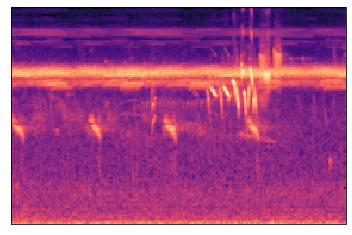

In [19]:
#만든 dataset 확인하기

x, y = dataset[np.random.choice(len(dataset))] #random으로 ds에서 하나 받아오기
print(x.shape, y.shape, np.where(y>=0.5)) # x는 3층(image, image, image), y는 label, np.where은 하나뽑은 녀석이 label에서 몇번에 등록된 해당하는지
lbd.specshow(x[0])

In [20]:
###############################################
'''
                 PIPE LINE 2.2
                불러온 데이터를
             Augmentation 한 이후
                dataset으로 저장
                                              '''
###############################################




'\n                 PIPE LINE 2.2\n                불러온 데이터를\n             Augmentation 한 이후\n                dataset으로 저장\n                                              '

In [17]:
##########################
##     Time Warp 함수    ##
##########################

def time_warp(spec, W=5):
    num_rows = spec.shape[1]
    spec_len = spec.shape[2]
    device = spec.device
    
    y = num_rows//2
    horizontal_line_at_ctr = spec[0][y]
    assert len(horizontal_line_at_ctr) == spec_len
    
    point_to_warp = horizontal_line_at_ctr[random.randrange(W, spec_len - W)]
    assert isinstance(point_to_warp, torch.Tensor)

    # Uniform distribution from (0,W) with chance to be up to W negative
    dist_to_warp = random.randrange(-W, W)
    src_pts, dest_pts = (torch.tensor([[[y, point_to_warp]]], device=device), 
                         torch.tensor([[[y, point_to_warp + dist_to_warp]]], device=device))
    warped_spectro, dense_flows = sparse_image_warp(spec, src_pts, dest_pts)
    return warped_spectro.squeeze(3)

In [18]:
class Warp_Aug_BirdClefDataset(BirdClefDataset):
    def __init__(self, audio_image_store, meta, sr=SR, is_train=True, num_classes=Num_classes, duration=Duration):
        
        self.audio_image_store = audio_image_store ##audio np array랑 filename 저장된 dic
        self.meta = meta.copy().reset_index(drop=True) ##meta는 df
        self.sr = sr
        self.is_train = is_train
        self.num_classes = num_classes
        self.duration = duration
        self.audio_length = self.duration * self.sr
        
    
    def normalize(self, image):
        image = image.astype('float32', copy=False) / 255.0
        image = np.stack([image, image, image])
        return image
    
    def __len__(self):
        return len(self.meta)
    
    
    ##이 dataset의 단점이 있는 파트
    def __getitem__(self, idx):
        row = self.meta.iloc[idx]  #df에서 데이터 하나 불러옴
        image = self.audio_image_store[row.filename] #불러온 데이터의 filename으로 audio_image_store에서 image에 해당하는 np array 받아서 image에 저장
        
        image = image[np.random.choice(len(image))] 
        
        
        ## Augmentation할때 Torch(1,x,x) -> Torch(1,x,x) 인 함수라서 torch로 변경후
        ## Unsqueeze로 Image(x,x) -> (1,x,x) 해준 후
        ## 함수 돌리고
        ## Squeeze로 (1,x,x) -> (x,x) 해준 후
        ## 다시 numpy 로 만들어 줌
        image = torch.from_numpy(image)
        image = image.unsqueeze(0)
        image = time_warp(image, W=2)
        image = image.squeeze(0)
        image = image.numpy()
        
        image = self.normalize(image)
        
        ## Label smoothing. 해당 라벨은 0.995, 나머지는 0.0025로 초기화
        t = np.zeros(self.num_classes, dtype=np.float32) + 0.0025 
        t[row.label_id] = 0.995
        
        return image, t

In [23]:
a_dataset = Warp_Aug_BirdClefDataset(audio_image_store, meta=df, sr=SR, duration=Duration, is_train=True)

(3, 128, 281) (397,) (array([305], dtype=int64),)


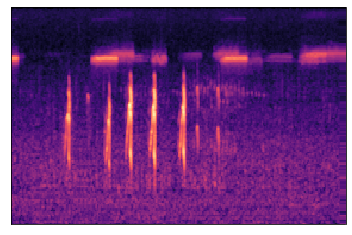

In [48]:
#만든 dataset 확인하기

xa, ya = a_dataset[np.random.choice(len(a_dataset))] #random으로 ds에서 하나 받아오기
print(xa.shape, ya.shape, np.where(ya>=0.5)) # x는 3층(image, image, image), y는 label, np.where은 하나뽑은 녀석이 label에서 몇번에 등록된 해당하는지lbd.specshow(x[0])
lbd.specshow(xa[0])

In [19]:
################################
##     Frequency Mask 함수    ##
################################

def freq_mask(spec, F=30, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    num_mel_channels = cloned.shape[1]
    
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero): cloned[0][f_zero:mask_end] = 0
        else: cloned[0][f_zero:mask_end] = cloned.mean()
    
    return cloned

In [20]:
################################
##       Time Mask 함수       ##
################################

def time_mask(spec, T=40, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    len_spectro = cloned.shape[2]
    
    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero): cloned[0][:,t_zero:mask_end] = 0
        else: cloned[0][:,t_zero:mask_end] = cloned.mean()
    return cloned

In [21]:
class Mask_Aug_BirdClefDataset(BirdClefDataset):
    def __init__(self, audio_image_store, meta, sr=SR, is_train=True, num_classes=Num_classes, duration=Duration):
        
        self.audio_image_store = audio_image_store ##audio np array랑 filename 저장된 dic
        self.meta = meta.copy().reset_index(drop=True) ##meta는 df
        self.sr = sr
        self.is_train = is_train
        self.num_classes = num_classes
        self.duration = duration
        self.audio_length = self.duration * self.sr
        
    
    def normalize(self, image):
        image = image.astype('float32', copy=False) / 255.0
        image = np.stack([image, image, image])
        return image
    
    def __len__(self):
        return len(self.meta)
    
    
    ##이 dataset의 단점이 있는 파트
    def __getitem__(self, idx):
        row = self.meta.iloc[idx]  #df에서 데이터 하나 불러옴
        image = self.audio_image_store[row.filename] #불러온 데이터의 filename으로 audio_image_store에서 image에 해당하는 np array 받아서 image에 저장
        
        
        
        image = image[np.random.choice(len(image))] 
        
        
        ## Augmentation할때 Torch(1,x,x) -> Torch(1,x,x) 인 함수라서 torch로 변경후
        ## Unsqueeze로 Image(x,x) -> (1,x,x) 해준 후
        ## 함수 돌리고
        ## Squeeze로 (1,x,x) -> (x,x) 해준 후
        ## 다시 numpy 로 만들어 줌
        image = torch.from_numpy(image * 1.0)
        image = image.unsqueeze(0)
        image = time_mask(freq_mask(image, num_masks=2), num_masks=2)
        image = image.squeeze(0)
        image = image.numpy()
        
        image = self.normalize(image)
        
        ## Label smoothing. 해당 라벨은 0.995, 나머지는 0.0025로 초기화
        t = np.zeros(self.num_classes, dtype=np.float32) + 0.0025 
        t[row.label_id] = 0.995
        
        return image, t

In [28]:
m_dataset = Mask_Aug_BirdClefDataset(audio_image_store, meta=df, sr=SR, duration=Duration, is_train=True)

(3, 128, 281) (397,) (array([13], dtype=int64),)


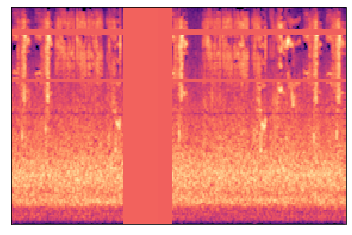

In [32]:
#만든 dataset 확인하기

xm, ym = m_dataset[np.random.choice(len(m_dataset))] #random으로 ds에서 하나 받아오기
print(xm.shape, ym.shape, np.where(ym>=0.5)) # x는 3층(image, image, image), y는 label, np.where은 하나뽑은 녀석이 label에서 몇번에 등록된 해당하는지lbd.specshow(x[0])
lbd.specshow(xm[0])

In [33]:
######################################
##       Dataset 합치기 예시       ##
#####################################

Merged_dataset = torch.utils.data.ConcatDataset([dataset, a_dataset, m_dataset])
len(Merged_dataset)

188622

(3, 128, 281) (397,) (array([291], dtype=int64),)


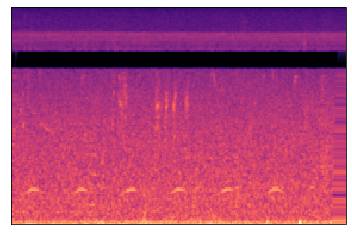

In [40]:
xt, yt = Merged_dataset[np.random.choice(len(Merged_dataset))] #random으로 ds에서 하나 받아오기
print(xt.shape, yt.shape, np.where(yt>=0.5)) # x는 3층(image, image, image), y는 label, np.where은 하나뽑은 녀석이 label에서 몇번에 등록된 해당하는지lbd.specshow(x[0])
lbd.specshow(xt[0])

In [21]:
###############################################
'''
                 PIPE LINE 2.5
          Training, evaluate 모델 만들기
                                              '''
###############################################


''' 1 train == x fold (x == 데이터셋 쪼갠 수,,  k fold)
    1 fold  == x epochs (x == 반복학습 수)
    1 epoch == x step(x는 dataset에서 학습해야되는 step수)'''

'''
    net (model) 정의 블럭 -> get_model
    get_model 호출 블럭 -> one fold
    criterion 정의 블럭 -> one_fold
    scheduler 정의 -> one fold
    data_loader 정의 -> one fold
    
    
    epoch 설정 -> train
    n_split 설정 -> split
'''



'\n    net (model) 정의 블럭 -> get_model\n    get_model 호출 블럭 -> one fold\n    criterion 정의 블럭 -> one_fold\n    scheduler 정의 -> one fold\n    data_loader 정의 -> one fold\n    \n    \n    epoch 설정 -> train\n    n_split 설정 -> split\n'

In [22]:
## Fold 계산 후 값을 저장하기 위한 autosave
class AutoSave:
    def __init__(self, top_k=2, metric='f1', mode='min', root=None, name='ckpt'):
        self.top_k = top_k
        self.logs = []
        self.metric = metric
        self.mode = mode
        self.root = Path(root or Root_Path)
        assert self.root.exists()
        self.name = name
        
        self.top_models = []
        self.top_metrics = []
    
    def rank(self, val):
        r = -1
        for top_val in self.top_metrics:
            if val <= top_val:
                return r
            r += 1
            
        return r
    
    def log(self, model, metrics):
        metric = metrics[self.metric] #list에 f1 저장
        rank = self.rank(metric) #성능(f1) 레이팅
        
        self.top_metrics.insert(rank+1, metric) 
        if len(self.top_metrics) > self.top_k:
            self.top_metrics.pop(0)
            
        self.logs.append(metrics)
        self.save(model, metric, rank, metrics['epoch'])
        
    def save(self, model, metric, rank, epoch):
        t = time.strftime("%Y%m%d%H%M%S")
        name = "{}_epoch_{:02d}_{}_{:.04f}_{}".format(self.name, epoch, self.metric, metric, t)
        name = re.sub(r"[^\w_-]", "", name) + ".pth"
        path = self.root.joinpath(name)
        
        old_model = None
        self.top_models.insert(rank+1, name)
        if len(self.top_models) > self.top_k:
            old_model = self.root.joinpath(self.top_models[0])
            self.top_models.pop(0)
            
        torch.save(model.state_dict(), path.as_posix())
        
        if old_model is not None:
            old_model.unlink()
        self.to_json()
        
        
        
    def to_json(self):
        name = "{}_logs".format(self.name)
        name = re.sub(r"[^\w_-]", "", name) + ".json"
        path = self.root.joinpath(name)

        with path.open("w") as f:
            json.dump(self.logs, f, indent=2)

In [23]:
Train_Batch_Size = 16
Train_Num_Workers = 0

Val_Batch_Size = 16
Val_Num_Workers = 0

In [24]:
#############################################
##             기본 conv 블럭              ##
## 패딩, 노말라이제션, active func 등 묶음 ##
#############################################



def Convlayer(in_ch, out_ch, kernel_size=3, stride=2, use_leaky = True, use_inst_norm=True, use_pad=True):
    
    if use_pad:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True)
     
    
    if use_inst_norm:
        norm = nn.InstanceNorm2d(out_ch)
    else:
        norm = nn.BatchNorm2d(out_ch)
        
        
    if use_leaky:
        actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    else:
        actv = nn.GELU()
    
    return nn.Sequential(conv, norm, actv)

In [25]:
###############################
##          Resblock         ##
## 안에 더 deep 하게 가능    ##
###############################

class Resblock(nn.Module):
    def __init__(self, in_features, use_dropout=True, dropout_ratio=0.5):
        super().__init__()
        models = list()
        
        models.append(Convlayer(in_features, in_features, 1, 1, use_leaky=True, use_inst_norm=False, use_pad=False))
        models.append(nn.ReflectionPad2d(1))
        models.append(Convlayer(in_features, in_features, 3, 1, use_leaky=True, use_inst_norm=False, use_pad=False))
        models.append(nn.ReflectionPad2d(1))
        models.append(Convlayer(in_features, in_features, 3, 1, use_leaky=True, use_inst_norm=False, use_pad=False))
        
        self.res = nn.Sequential(*models)
        
    
    def forward(self, x):
        x = x + self.res(x)
        x = F.relu(x)
        return x

In [26]:
###################################### 
##         model_name으로부터       ##
##        model(==net) 불러옴       ##
##     num_classes = label 가짓수   ##
######################################

def get_model(name, num_classes=Num_classes):
    
    
    if 'resnet' in name: ##resnet 쓰고싶으면
        model = torch.hub.load('pytorch/vision:v0.6.0', name, pretrained=True) ##python ver에 따라서 v0.6.0이나 0.9.0 등 고를것
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
    
    elif 'resnext' in name: ## resnext 쓰고싶으면(이게 resnet보다 좋음)
        model = models.resnext50_32x4d()
        model.fc = nn.Linear(model.fc.in_features, num_classes)

        
    elif 'efficientnet' in name: ## timm라이브러리에 effnet 말고도 많이 있음)
        model = timm.create_model('tf_efficientnet_b4_ns', pretrained = True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        
    else: ##내가 만든 전용 모델 쓰고싶으면
        model = list()
        model.append(Resblock(3))
        model.append(Convlayer(3, 1, 3, 3, use_leaky=False, use_inst_norm=False, use_pad=False))
        model.append(nn.Flatten())
        model.append(nn.Linear(3906,397)) ##3906
        model = nn.Sequential(*model)
    
    return model

In [27]:
#####################################
##           One Step              ##
##   train_loader 값을 net에 넣음  ##
#####################################

def one_step(xb,yb, net, criterion, optimizer, scheduler = None):
    
    xb, yb = xb.to(device), yb.to(device)
    
    optimizer.zero_grad()
    out = net(xb) # net은 model, 예를들면 resnet
    
    loss = criterion(out, yb)
    loss.backward()
    optimizer.step()
    
    
    ## F1 Score 계산
    with torch.no_grad():
        l = loss.item()
        
        out = out.sigmoid() ##모델따라서 바꿀것(eval것도 같이 바꿔줘야함)
        
        yb = (yb > 0.5) * 1.0 ## Label smoothing의 threshold
        
        lrap = label_ranking_average_precision_score(yb.cpu().numpy(), out.cpu().numpy()) #점수계산용
        
        out = (out > 0.5) * 1.0
        
        prec = (out * yb).sum() / (1e-6 + out.sum()) ##precision
        rec = (out * yb).sum() / (1e-6 + yb.sum()) ##recall
        f1 = 2 * prec * rec/(1e-6+prec+rec) ##F1 score, 조화평균
        
    
    if scheduler is not None:
        scheduler.step()
        
    return l, lrap, f1.item(), rec.item(), prec.item()

In [28]:
####################################
##           One eval             ##
##   val_loader 값을 net에 넣음   ##
####################################

@torch.no_grad() #함수 데코레이터 ##evaluate를 torch.no_Grad인 상태로 실행하겠다.
def evaluate(net, criterion, val_loader):
    
    net.eval()
    outs, y = [], []
    
    val_loader = tqdm(val_loader, leave=False, total=len(val_loader))
    
    for icount, (xb, yb) in enumerate(val_loader):
        y.append(yb.to(device))
        xb = xb.to(device)
        out = net(xb)
        
        outs.append(out)
    
    
    ## y, outs 를 list에서 torch로 변경, 이어붙인후 y, out에 저장    
    y = torch.cat(y) 
    out = torch.cat(outs)
    
    l = criterion(out, y).item()
    out = out.sigmoid() #one_Step의 활성화와 맞출것
    
    y = (y > 0.5) * 1.0
    lrap = label_ranking_average_precision_score(y.cpu().numpy(), out.cpu().numpy())
    out = (out>0.5) * 1.0
    
    
    ## F1 Score 계산
    prec = ((out*y).sum()/(1e-6 + out.sum())).item()
    rec = ((out*y).sum()/(1e-6 + y.sum())).item()
    f1 = 2*prec*rec/(1e-6+prec+rec)
    
    return l, lrap, f1, rec, prec



'''
model.eval()에 관하여
eval은 함수를 그 자체로 실행시켜준다는 뜻이다.
즉 model.eval()을 하게 되면 스위치를 꺼버려서 예를들면 dropout, batchnorm 등등을 다 업데이트 안하고
그냥 그대로 실행만 하겠다는 뜻이다.

그래서 evaluate하는 클래스에서 torch.no_grad() 랑 model.eval()을 같이 쓰는 편임
'''

'\nmodel.eval()에 관하여\neval은 함수를 그 자체로 실행시켜준다는 뜻이다.\n즉 model.eval()을 하게 되면 스위치를 꺼버려서 예를들면 dropout, batchnorm 등등을 다 업데이트 안하고\n그냥 그대로 실행만 하겠다는 뜻이다.\n\n그래서 evaluate하는 클래스에서 torch.no_grad() 랑 model.eval()을 같이 쓰는 편임\n'

In [29]:
######################################
##           One epoch               ##
##   one_step, eval 값 묶어서 반환   ##
######################################

def one_epoch(net, criterion, optimizer, scheduler, train_loader, val_loader):
    
    net.train()
    l, lrap, prec, rec, f1, icount = 0., 0., 0., 0., 0., 0
    train_loader = tqdm(train_loader, leave = False)
    epoch_bar = train_loader
    
    
    for (xb, yb) in epoch_bar:
        
        _l, _lrap, _f1, _rec, _prec = one_step(xb, yb, net, criterion, optimizer)
        
        l += _l
        lrap += _lrap
        f1 += _f1
        rec += _rec
        prec += _prec
        
        icount += 1
        
        
        ##postfilx 왜 하는지 모르겠음.. 나중에 공부할것
        if hasattr(epoch_bar, 'set_postfix') and not icount%10 :
            epoch_bar.set_postfix(
                loss = "{:.6f}".format(l/icount),
                lrap = "{:.3f}".format(lrap/icount),
                prec = "{:.3f}".format(prec/icount),
                rec = "{:.3f}".format(rec/icount),
                f1="{:3f}".format(rec/icount)
            )
            
        
    scheduler.step()
    
    
    ##평균치 구함
    l /= icount
    lrap /= icount
    f1 /= icount
    rec /= icount
    prec /= icount
    
    # val_loader 을 net에 넣는 eval함수 결과
    l_val, lrap_val, f1_val, rec_val, prec_val = evaluate(net, criterion, val_loader)
    
    # train_loader넣은 값과 val_loader을 net에 넣은값 묶어서 반환
    return (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val)

In [30]:
######################################### 
##             one_fold                ##
##    net, criterion, optimizer, scheduler, data_loader  불러옴     ##
##        epoch 다 돌림               ##
#######################################


def one_fold(model_name, fold, train_set, val_set, epochs, save=True, save_root = None):
    
    
    ## f1_Val 저장
    save_root = Path(save_root) or Root_Path
    saver = AutoSave(root=save_root, name=f"birdclef_{model_name}_fold{fold}", metric="f1_val")
    
    
    ## 모델 param 불러오기

    #방법1. 새 모델 생성
    net = get_model(model_name).to(device)
    
    #방법2. 내 모델 불러와서 이어서 학습시키기
    #p = Path("/Users/ansgh/PycharmProjects/kaggle_notebook/input/birdclef-2021/efficientnet_sr32000_d7_v1_v1/birdclef_efficientnet_fold2_epoch_02_f1_val_03480_20210525221814.pth")
    #net = load_net(p.as_posix())
    
    criterion = nn.BCEWithLogitsLoss() 
    optimizer = optim.Adam(net.parameters(), lr=8e-4) 
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=epochs)
    
    
    ## 데이터 불러오기
    ## train에서 df를 train_set이랑 val_set이랑 나눠서 넘겨줌(setdiff1d 참고)
    ## Audio_image_store -> Mel_img 불러옴
    
    ## Augmentation 진행후 합쳐줌
    train_data1 = BirdClefDataset(audio_image_store, meta=df.iloc[train_set].reset_index(drop=True),
                           sr=SR, duration=Duration, is_train=True)
    train_data2 = Warp_Aug_BirdClefDataset(audio_image_store, meta=df.iloc[train_set].reset_index(drop=True),
                           sr=SR, duration=Duration, is_train=True)
    train_data3 = Mask_Aug_BirdClefDataset(audio_image_store, meta=df.iloc[train_set].reset_index(drop=True),
                           sr=SR, duration=Duration, is_train=True)
    Merged_train_data = torch.utils.data.ConcatDataset([train_data1, train_data2, train_data3])
    #Data_loader -> (batchsize, dataset차원)으로 불러옴 (ex, (batchsize, 3, 256, 256))
    train_loader = DataLoader(Merged_train_data, batch_size=Train_Batch_Size, num_workers=Train_Num_Workers, shuffle=True, pin_memory=True)
    

    ## Valdata
    val_data = BirdClefDataset(audio_image_store, meta=df.iloc[val_set].reset_index(drop=True),  sr=SR, duration=Duration, is_train=False)
    val_loader = DataLoader(val_data, batch_size=Val_Batch_Size, num_workers=Val_Num_Workers, shuffle=False)
    
    
    
    #### Epoch 진행 ####
    epochs_bar = tqdm(list(range(epochs)), leave=False)
    for epoch in epochs_bar:
        epochs_bar.set_description(f"[Epoch in one fold {epoch:02d}]")
        net.train()
        
        (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val) \
        = one_epoch(net=net,
                    criterion=criterion,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    train_loader=train_loader,
                    val_loader=val_loader,
                   )
     
    
        
        if save:
            metrics = {
                "loss": l, "lrap": lrap, "f1": f1, "rec": rec, "prec": prec,
                "loss_val": l_val, "lrap_val": lrap_val, "f1_val": f1_val, "rec_val": rec_val, "prec_val": prec_val,
                "epoch": epoch,
            }
            saver.log(net, metrics)

In [31]:
def train(model_name, epochs, save=True, n_splits =n_splits , seed=seed, save_root=None, suffix="", folds=None):
    
    gc.collect() #garbage collection, 객채들을 순회하며 객채가 안쓰이면 자동으로 삭제해줌
    torch.cuda.empty_cache()
    
    
    ## Save
    save_root = save_root or (Root_Path + f'/{model_name}{suffix}')
    save_root = Path(save_root)
    save_root.mkdir(exist_ok=True, parents=True)
    
    
    # Fold labeling 한것(make_df에서) 이용해서 fold끼리 묶어줌
    fold_bar = tqdm(df.reset_index().groupby('fold').index.apply(list).items(), total=df.fold.max()+1)
    
    
    for fold, val_set in fold_bar:
        if folds and not fold in folds:
            continue
        
        print(f"\n [one Fold {fold}]")
        fold_bar.set_description(f"[Fold {fold}]")
        
        # Train_set과 val_set 나눔.  (df - val_set = train_set)
        train_set = np.setdiff1d(df.index, val_set)
        
        
        one_fold(model_name, fold=fold, train_set=train_set, val_set=val_set, epochs=epochs, save=save, save_root=save_root)
        
        
        ##메모리 정리
        gc.collect()
        torch.cuda.empty_cache()

In [ ]:
train('resnet152', epochs = 16, suffix=f"_sr{SR}_d{Duration}_v1_v1", folds=[0])

  0%|          | 0/5 [00:00<?, ?it/s]


 [one Fold 0]


Using cache found in C:\Users\ansgh/.cache\torch\hub\pytorch_vision_v0.6.0


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/9432 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/9432 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/9432 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/9432 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/9432 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/9432 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/9432 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/9432 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/9432 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/9432 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/9432 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/9432 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/9432 [00:00<?, ?it/s]

  0%|          | 0/786 [00:00<?, ?it/s]

  0%|          | 0/9432 [00:00<?, ?it/s]

In [ ]:
'''### 여러 모델 성능 비교할 때 ###

Model_names = ['resnest50', 'mymodel']

for model_name in Model_names:
    train(model_name, epochs = 1, suffix=f"_sr{SR}_d{DURATION}_v1_v1", folds=[0])
    
    
'''

In [74]:
'''
train 까지 진행했으면 폴더에 보면 'net이름 + sr + ...' 으로 된 폴더에 '.pth', '.json' 저장 돼 있을거임

그걸 input으로 다음 파이프라인 진행할 것임

'''

"\ntrain 까지 진행했으면 폴더에 보면 'net이름 + sr + ...' 으로 된 폴더에 '.pth', '.json' 저장 돼 있을거임\n\n그걸 input으로 다음 파이프라인 진행할 것임\n\n"

In [ ]:
###############################################
'''
                 PIPE LINE 3
          모델 불러와서 평가하기
                                              '''
###############################################

'''
PipeLine 으로 따로따로 작업하려면

class MelSpecComputer
def mono_to_color
class BirdCLEFDataset
불러올것


'''

In [ ]:
Num_classes = 397
SR = 32_000
Duration = 5
THRESH = 0.25


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

TEST_AUDIO_ROOT = Path("../input/birdclef-2021/test_soundscapes")
SAMPLE_SUB_PATH = "../input/birdclef-2021/sample_submission.csv"
TARGET_PATH = None
    
    
## Test Audio 에 아무것도 없으면(룰 상 제출용 커밋할때만 test_soundscapes에 접근가능하기때문에 연습때는 train_soundscapes꺼 씀)
if not len(list(TEST_AUDIO_ROOT.glob("*.ogg"))):
    TEST_AUDIO_ROOT = Path("../input/birdclef-2021/train_soundscapes")
    SAMPLE_SUB_PATH = None
    # SAMPLE_SUB_PATH = "../input/birdclef-2021/sample_submission.csv"
    TARGET_PATH = Path("../input/birdclef-2021/train_soundscape_labels.csv")

In [ ]:
'''

class MelSpecComputer
def mono_to_color
class BirdCLEFDataset
불러와야 함

'''

In [ ]:
data = pd.DataFrame(
     [(path.stem, *path.stem.split("_"), path) for path in Path(TEST_AUDIO_ROOT).glob("*.ogg")],
    columns = ["filename", "id", "site", "date", "filepath"]
)
print(data.shape)
data.head()

In [ ]:
## 메타데이터(정답지) 불러오기
df_train = pd.read_csv("../input/birdclef-2021/train_metadata.csv")

LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df_train["primary_label"].unique()))}
INV_LABEL_IDS = {val: key for key,val in LABEL_IDS.items()}

In [ ]:
test_data = BirdCLEFDataset(data=data)
len(test_data), test_data[0].shape, test_data[1].shape
# 20 -> train_soundscape에 20개 있음
# 120 -> 10분(각 train_soundscape음성) / 5초
# 3 - > normalize에서 3쌓음
# 128, 201 -> 이미지 사이즈

In [32]:
NUM_CLASSES = 397
def load_net(checkpoint_path, num_classes=NUM_CLASSES):
    net = timm.create_model('tf_efficientnet_b4_ns', pretrained = False)
    net.classifier = nn.Linear(net.classifier.in_features, num_classes)
    
    dummy_device = torch.device("cpu")
    d = torch.load(checkpoint_path, map_location=dummy_device)
    for key in list(d.keys()):
        d[key.replace("model.", "")] = d.pop(key)
    net.load_state_dict(d)
    net = net.to(device)
    net = net.eval()
    return net

In [96]:
checkpoint_paths = [
    Path("../input/bird-clef/resnet152_sr32000_d7_v1_v1/birdclef_resnet152_fold0_epoch_00_f1_val_01435_20210513145723.pth"),
]


nets = [
        load_net(checkpoint_path.as_posix()) for checkpoint_path in checkpoint_paths
]

FileNotFoundError: [Errno 2] No such file or directory: '../input/bird-clef/resnet152_sr32000_d7_v1_v1/birdclef_resnet152_fold0_epoch_00_f1_val_01435_20210513145723.pth'

In [ ]:
## Threshold 보다 높은 값만 pred라는 list에 저장

@torch.no_grad()
def get_thresh_preds(out, thresh=None):
    thresh = thresh or THRESH
    o = (-out).argsort(1)
    npreds = (out > thresh).sum(1)
    preds = []
    for oo, npred in zip(o, npreds):
        preds.append(oo[:npred].cpu().numpy().tolist())
    return preds

In [ ]:
## pred라는 list를 받아서 그 안에 새이름이 있으면 keep, 없으면 'nocall'로 변경
def get_bird_names(preds):
    bird_names = []
    for pred in preds:
        if not pred:
            bird_names.append("nocall")
        else:
            bird_names.append(" ".join([INV_LABEL_IDS[bird_id] for bird_id in pred]))
    return bird_names

In [ ]:
##predict 실행해서 label 확률표 반환

def predict(nets, test_data, names=True):
    preds = []
    with torch.no_grad():
        for idx in  tqdm(list(range(len(test_data)))):
            xb = torch.from_numpy(test_data[idx]).to(device)
            pred = 0.
            for net in nets:
                o = net(xb)
                o = torch.sigmoid(o)

                pred += o

            pred /= len(nets)
            
            if names:
                pred = get_bird_names(get_thresh_preds(pred))

            preds.append(pred)
    return preds

In [ ]:
pred_probas = predict(nets, test_data, names=False)
print(len(pred_probas))

In [ ]:
##새 이름 list로 전
preds = [get_bird_names(get_thresh_preds(pred, thresh=THRESH)) for pred in pred_probas]

In [ ]:
######################################
##    submission 만들기 위한 작업   ##
######################################


def preds_as_df(data, preds):
    sub = {
        "row_id": [],
        "birds": [],
    }
    
    for row, pred in zip(data.itertuples(False), preds):
        row_id = [f"{row.id}_{row.site}_{5*i}" for i in range(1, len(pred)+1)]
        sub["birds"] += pred
        sub["row_id"] += row_id
        
    sub = pd.DataFrame(sub)
    
    if SAMPLE_SUB_PATH:
        sample_sub = pd.read_csv(SAMPLE_SUB_PATH, usecols=["row_id"])
        sub = sample_sub.merge(sub, on="row_id", how="left")
        sub["birds"] = sub["birds"].fillna("nocall")
    return sub

In [ ]:
sub = preds_as_df(data, preds)
print(sub.shape)
sub

In [ ]:
sub.to_csv("submission.csv", index=False)

In [ ]:
######################################
##         성능 확인하기            ##
######################################


def get_metrics(s_true, s_pred):
    s_true = set(s_true.split())
    s_pred = set(s_pred.split())
    n, n_true, n_pred = len(s_true.intersection(s_pred)), len(s_true), len(s_pred)
    
    prec = n/n_pred
    rec = n/n_true
    f1 = 2*prec*rec/(prec + rec) if prec + rec else 0
    
    return {"f1": f1, "prec": prec, "rec": rec, "n_true": n_true, "n_pred": n_pred, "n": n}

In [ ]:
if TARGET_PATH:
    sub_target = pd.read_csv(TARGET_PATH)
    sub_target = sub_target.merge(sub, how="left", on="row_id")
    
    print(sub_target["birds_x"].notnull().sum(), sub_target["birds_x"].notnull().sum())
    assert sub_target["birds_x"].notnull().all()
    assert sub_target["birds_y"].notnull().all()
    
    df_metrics = pd.DataFrame([get_metrics(s_true, s_pred) for s_true, s_pred in zip(sub_target.birds_x, sub_target.birds_y)])
    
    print(df_metrics.mean())


In [ ]:
sub_target[sub_target.birds_y != "nocall"]

In [ ]:
sub_target[sub_target.birds_x != "nocall"]

In [ ]:
## 성능 증가 고려사항 http://www.gisdeveloper.co.kr/?p=8443